<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;"> Measuring Data Drift on a Binary Classification Task </h1>

In this example, we consider a binary classification task of human orientation while exercising. That is, given the location of 17 key-points of the body such as the nose, shoulders, wrist, hips, ankles, etc., the model tries to predict whether the person is in a horizontal (see image 1 below) or a vertical (see image 2 below) position. 

Input: 34-dimensional vector that contains the x and y positions of the 17 key-points.\
Output: Orientation (horizontal or vertical)

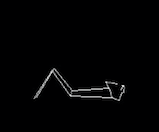
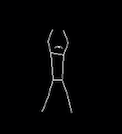

In this notebook, we will see how we can use UpTrain package to identify data drift and identify out of distribution cases on real-world data.

### Install the required packages for this example

In [1]:
!pip install torch imgaug

In [2]:
import os
import subprocess
import zipfile
import numpy as np
import torch
import uptrain

import sys
sys.path.insert(0,'..')

from helper_files import read_json, write_json, KpsDataset
from helper_files import body_length_signal, plot_all_cluster

/Users/sourabhagrawal/miniconda3/envs/prod_merge1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download dataset from remote

In [3]:
data_dir = "data"
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/data.zip"
orig_training_file = 'data/training_data.json'
if not os.path.exists(data_dir):
    try:
        # Most Linux distributions have Wget installed by default.
        # Below command is to install wget for MacOS
        wget_installed_ok = subprocess.call("brew install wget", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print("Successfully installed wget")
    except:
        dummy = 1
    try:
        if not os.path.exists("data.zip"):
            file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            print("Data downloaded")
        with zipfile.ZipFile("data.zip", 'r') as zip_ref:
            zip_ref.extractall("./")
        full_training_data = read_json(orig_training_file)
        np.random.seed(1)
        np.random.shuffle(full_training_data)
        reduced_training_data = full_training_data[0:1000]
        write_json(orig_training_file, reduced_training_data)
        print("Prepared Example Dataset")
        os.remove("data.zip")
    except Exception as e:
        print(e)
        print("Could not load training data")

#### Type of data files

In [4]:
# Training data
training_file = 'data/training_data.json'

# A testing dataset to evaluate model performance
golden_testing_file = 'data/golden_testing_data.json'

# The data-points which the models sees in production
real_world_test_cases = 'data/real_world_testing_data.json'

# To annotate the collected data points, we extract the ground truth from a master annotation file 
# (we can also import from any other annotation pipelines such as an annotation job on Mechanical turk).
annotation_args = {'master_file': 'data/master_annotation_data.json'}

### Step 1: Train our Deep Neural Network model

In [5]:
from helper_files import get_accuracy_torch, train_model_torch, BinaryClassification
train_model_torch(training_file, 'version_0')

Next, we get the model accuracy on testing dataset

In [6]:
get_accuracy_torch(golden_testing_file, 'version_0')

Evaluating model: version_0  on  15731  data-points


0.9253702879664357

### Step 2: Define the list of checks to perform on model

In this example, we define a three different data drift checks on the real-world data.

1. In the first check, we use clustering on training and real-world datasets to identify any distribution shift between real-world data and the reference dataset (the training dataset in this case).

In [7]:
check1 = {
    'type': uptrain.Anomaly.DATA_DRIFT,
    'reference_dataset': orig_training_file,
    'is_embedding': True,
    "measurable_args": {
        'type': uptrain.MeasurableType.INPUT_FEATURE,
        'feature_name': 'kps'
    },
}

2. Next, we measure data drift for only the first feature: X co-ordinate of the Head keypoint. This is because we might want to see if specific features in the input are drifting or not. 

In [8]:
check2 = {
    'type': uptrain.Anomaly.DATA_DRIFT,
    'reference_dataset': orig_training_file,
    "save_edge_cases": False,
    "measurable_args": {
        'type': uptrain.MeasurableType.SCALAR_FROM_EMBEDDING,
        'idx': 0,
        'extract_from': {
            'type': uptrain.MeasurableType.INPUT_FEATURE,
            'feature_name': 'kps'
        }
    },
}

3. Finally, we measure data drift for body length. Many times, functions on the input features might be more meaningful to look as compared to the raw features. In this case, we can use the location of the keypoints to determine body length of the user using the UpTrain Signals and monitor if we see any shifts in it's distribution.

In [9]:
check3 = {
    'type': uptrain.Anomaly.DATA_DRIFT,
    'reference_dataset': orig_training_file,
    'is_embedding': False,
    "save_edge_cases": False,
    "measurable_args": {
        'type': uptrain.MeasurableType.CUSTOM,
        'signal_formulae': uptrain.Signal("Body Length", body_length_signal),
    }
}

In [10]:
checks = [check1, check2, check3]

### Step 3: Define the training and evaluation arguments

In [11]:
# Define the training pipeline to annotate data and retrain the model automatically
training_args = {
    "annotation_method": {"method": uptrain.AnnotationMethod.MASTER_FILE, "args": annotation_args}, 
    "training_func": train_model_torch, 
    "orig_training_file": orig_training_file,
}

# Define evaluation pipeline to test retrained model against original model
evaluation_args = {
    "inference_func": get_accuracy_torch,
    "golden_testing_dataset": golden_testing_file,
}

### Step 4: Define the UpTrain Config

In [12]:
cfg = {
    "checks": checks, 
    "training_args": training_args,
    "evaluation_args": evaluation_args,

    # Retrain when 200 datapoints are collected in the retraining dataset
    "retrain_after": 200,
    
    # A local folder to store the retraining dataset
    "retraining_folder": "uptrain_smart_data_data_drift",
}

### Step 5: Initialize the UpTrain Framework with the config

In [13]:
# Initialize the UpTrain framework object with config 
# A url will pop up if tensorboard logging is true
framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data_data_drift
Deleting the folder:  uptrain_logs


### Step 6: Deploy the model in production

Ship the model to production worry-free because the UpTrain tool will ideantify any deta drifts, collect interesting data points and automatically retrain the model on them.

In [14]:
inference_batch_size = 16
model_dir = 'trained_models_torch/'
model_save_name = 'version_0'
real_world_dataset = KpsDataset(
    real_world_test_cases, batch_size=inference_batch_size, is_test=True
)
model = BinaryClassification()
model.load_state_dict(torch.load(model_dir + model_save_name))
model.eval()

for i,elem in enumerate(real_world_dataset):

    # Do model prediction
    inputs = {"kps": elem[0]["kps"], "id": elem[0]["id"]}
    x_test = torch.tensor(inputs["kps"]).type(torch.float)
    test_logits = model(x_test).squeeze() 
    preds = torch.round(torch.sigmoid(test_logits)).detach().numpy()

    # Log model inputs and outputs to the uptrain Framework to monitor data drift
    idens = framework.log(inputs=inputs, outputs=preds)

    # Retrain only once
    if framework.version > 1:
        break

50 edge cases identified out of 12944 total samples
100 edge cases identified out of 14784 total samples
150 edge cases identified out of 23264 total samples
200 edge cases identified out of 25088 total samples

Kicking off re-training
Creating retraining dataset: uptrain_smart_data_data_drift/1/training_dataset.json  by merging  data/training_data.json  and collected edge cases.

Model retraining done...

Generating comparison report...
Evaluating model: version_0  on  15731  data-points
Evaluating model: version_1  on  15731  data-points
---------------------------------------------
---------------------------------------------
Old model accuracy:  0.9253702879664357
Retrained model accuracy (ie 201 smartly collected data-points added):  0.9832178501048885
---------------------------------------------
---------------------------------------------


#### Hurray! Our model after retraining performs significantly better.

Next, we identify the clusters that cause the data drift by examining the plots of clusters that cause the data drift.

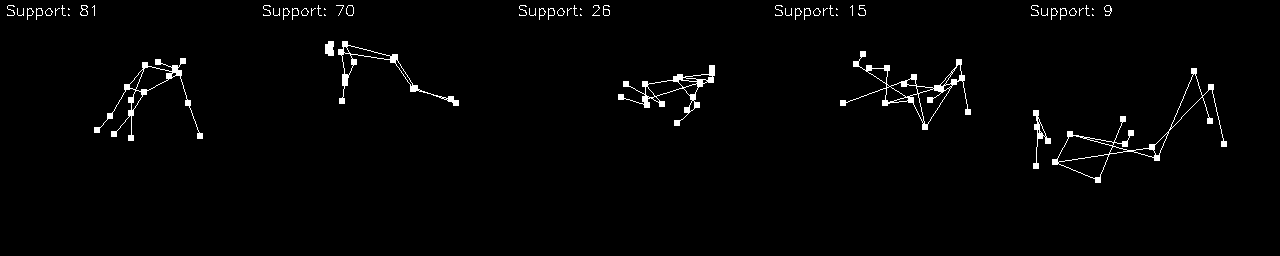

From the above plot generated while monitoring the model in production, we see that data drift occurs for many cases when the person is in a horizontal position. Specifically, push-ups during an exercise are causing the model predictions to go wrong. In the example of edge-case detection, we will use this insight to identify any push-up related data points and specifically retrain on them.

## Do more with UpTrain

Apart from data drift, UpTrain has many other features such as 
1. Checking for edge-cases and collecting them for automated retraining
2. Verifying data integrity, 
3. Monitoring model performance and accuracy of predictions, etc. 

To dig deeper into it, we recommend you checkout the other examples in the folder "deepdive_examples".